In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from plotting_tools import * 
import geopandas as gpd

In [2]:
%config InlineBackend.print_figure_kwargs = {'dpi': 110, 'bbox_inches': 'tight'}

In [3]:
locations_sub = ["S_Ua", "S_M1", "S_M3", "E_U", "Overall"]

In [4]:
vertical_lines = pd.to_datetime(["2020-03-02 00:00", "2020-03-10 00:00","2020-03-17 00:00", "2020-04-01 00:00", "2020-05-01 00:00"])

## Map visualizations

In [4]:
gebiete = gpd.read_file("MunichModel_shape/Gebiete.shp")
abschnitte = gpd.read_file("MunichModel_shape/Abschnitte.shp")
knoten = gpd.read_file("MunichModel_shape/Knoten.shp")

knoten["clear_name"] = ["Schmidbartlangerstr.", 
                  "Schenkendorfstr.", 
                  "Botanischer\nGarten", 
                  "Gräfelfinger\nStr.", #3
                  "Am\nLangwieder\nBach", #4
                  "Neue\nMessstelle 2", 
                  "WWT Gut Großlappen", 
                  "Gyßlinger Becken", #7
                  "Neue\nMessstelle 1", 
                  "WWT Gut Marienhof", #9
                  "Gesamt",
                  "Leopoldstr.", #11
                  "Neue\nMessstelle 4", 
                  "Zulauf\nGut Großlappen", 
                  "Savitstr.",
                  "Wintersteinstr.", ]

knoten["name"] = knoten.clear_name.apply(lambda x: manhole_clear_names[x])

In [6]:
prevalence_uniform = pd.read_csv("../../preprocessing/preprocessed_data/pop8/num_agents_infections_area_pop8.txt")
prevalence_uniform["Date"] = pd.to_datetime(start_date) + pd.to_timedelta(prevalence_uniform["t"], unit='hours')

In [8]:
prevalence_uniform["relative_prevalence"] = prevalence_uniform["NumInfected"] / prevalence_uniform["NumAgents"]
prevalence_uniform = prevalence_uniform.groupby(["Date", "area"])[["relative_prevalence"]].mean().reset_index()

In [11]:
prevalence_local = pd.read_csv("../../preprocessing/preprocessed_data/pop8_local/num_agents_infections_area_pop8_local.txt")
prevalence_local["Date"] = pd.to_datetime(start_date) + pd.to_timedelta(prevalence_local["t"], unit='hours')

In [12]:
prevalence_local57 = pd.read_csv("../../preprocessing/preprocessed_data/pop8_local57/num_agents_infections_area_pop8_local57.csv")
prevalence_local57["Date"] = pd.to_datetime(start_date) + pd.to_timedelta(prevalence_local57["t"], unit='hours')

In [13]:
prevalence_local["relative_prevalence"] = prevalence_local["NumInfected"] / prevalence_local["NumAgents"]
prevalence_local = prevalence_local.groupby(["Date", "area"])[["relative_prevalence"]].mean().reset_index()

prevalence_local57["relative_prevalence"] = prevalence_local57["NumInfected"] / prevalence_local57["NumAgents"]
prevalence_local57 = prevalence_local57.groupby(["Date", "area"])[["relative_prevalence"]].mean().reset_index()

In [14]:
vertical_lines = pd.to_datetime(["2020-03-02 00:00", "2020-03-10 00:00","2020-03-17 00:00", "2020-04-01 00:00", "2020-05-01 00:00"])
prevalence_uniform = prevalence_uniform.loc[prevalence_uniform.Date.isin(vertical_lines)]
prevalence_uniform.area = prevalence_uniform.area.astype(int)

prevalence_local = prevalence_local.loc[prevalence_local.Date.isin(vertical_lines)]
prevalence_local.area = prevalence_local.area.astype(int)

prevalence_local57 = prevalence_local57.loc[prevalence_local57.Date.isin(vertical_lines)]
prevalence_local57.area = prevalence_local57.area.astype(int)

In [15]:
from shapely.ops import unary_union
union_geom = unary_union(gebiete.geometry)
union_gdf = gpd.GeoDataFrame(geometry=[union_geom], crs=gebiete.crs)

/tmp/ipykernel_106289/1982784647.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


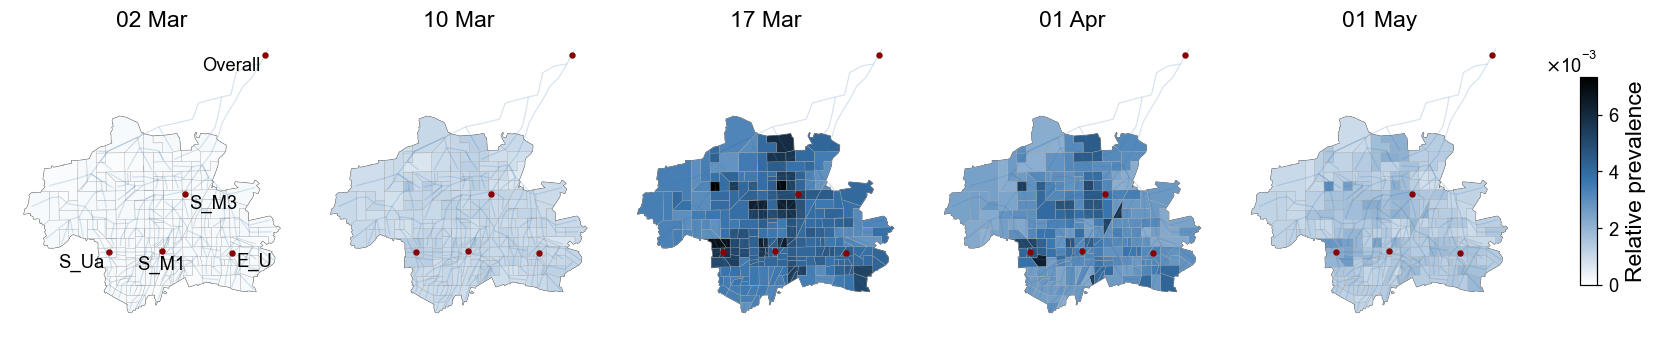

In [38]:
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter
cmap = mcolors.LinearSegmentedColormap.from_list(
    name="white_red",
    colors=[white, blue, black],
)
from matplotlib.colors import FuncNorm

# ScalarMappable as before
vmin=prevalence_uniform.relative_prevalence.min()
vmax=prevalence_uniform.relative_prevalence.max()

norm = mpl.colors.Normalize(
    vmin=vmin,
    vmax=vmax
)
#norm=FuncNorm(
#    (lambda x: np.log(x+1e-5), lambda x: np.exp(x-1e-5)),  # <-- notice the tuple here
#    vmin=vmin,
#    vmax=vmax
#)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []

fig, axs = plt.subplots(ncols=len(vertical_lines), figsize=(20*cm,6*cm), dpi=300)

for i in range(len(vertical_lines)):
    ax = axs[i]
    ax.set_title(vertical_lines[i].strftime("%d %b"))
    prevalence_uniform_sub = prevalence_uniform.loc[prevalence_uniform.Date == vertical_lines[i]]
    union_gdf.plot(ax=ax, color=very_light_grey, edgecolor="black", linewidth=0.5, alpha=0.8)
    gebiete_plot = gebiete.merge(prevalence_uniform_sub, left_on="Name", right_on="area", how="left")
    gebiete_plot.plot(
        ax=ax,
        column="relative_prevalence",
        cmap=cmap, #"viridis_r",
        norm=norm,
        vmin=vmin, vmax=vmax,
        edgecolor=medium_grey,
        linewidth=0.2,
        legend=False,
        legend_kwds={"label": "Relative prevalence", "shrink": 0.5}
    )
    # gebiete_plot[gebiete_plot.Name==62].plot(ax=ax, color=blue, edgecolor=medium_grey, linewidth=0.2, label="Area 62", zorder=10)
    txt_color = black
    abschnitte.plot(ax=ax, color=blue, label='Pipe', alpha=0.2, linewidth=0.8)
    knoten.iloc[[3,7,10,5,12]].plot(ax=ax, color=red, label='Sampling station', zorder=20, markersize=10)

    # orientation left of point
    if i==0:
        for idx, row in knoten.iloc[[3,7,10,5,12]].iterrows():
            if idx == 3 or idx==10:
                ax.annotate(
                    text=row['name'],
                    xy=(row.geometry.x, row.geometry.y),
                    xytext=(-3, -10),
                    textcoords="offset points",
                    ha="right",
                    color=txt_color,
                    fontsize=0.8*15  # Change this value to your desired font size
                )
            elif idx == 12:
                ax.annotate(
                    text=row['name'],
                    xy=(row.geometry.x, row.geometry.y),
                    xytext=(0, -12),
                    textcoords="offset points",
                    ha="center",
                    color=txt_color,
                    fontsize=0.8*15  # Change this value to your desired font size
                )
            else:
                ax.annotate(
                    text=row['name'],
                    xy=(row.geometry.x, row.geometry.y),
                    xytext=(3, -9 ),
                    textcoords="offset points",
                    ha="left",
                    color=txt_color,
                    fontsize=0.8*15  # Change this value to your desired font size
                )
    
    
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_axis_off()  # Remove plot borders

# manually carve out room on the right: [left, bottom, width, height] in figure fraction
cb_ax = fig.add_axes([0.92, 0.3, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cb_ax)
cbar.set_label("Relative prevalence")
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-3, 3))  # Adjust limits as needed
cb_ax.yaxis.set_major_formatter(formatter)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig("../plots/initialization_investigation/prevalence_pop8_uniform.png", dpi=300, bbox_inches='tight')


3
12
10
5


/tmp/ipykernel_8540/2381330446.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


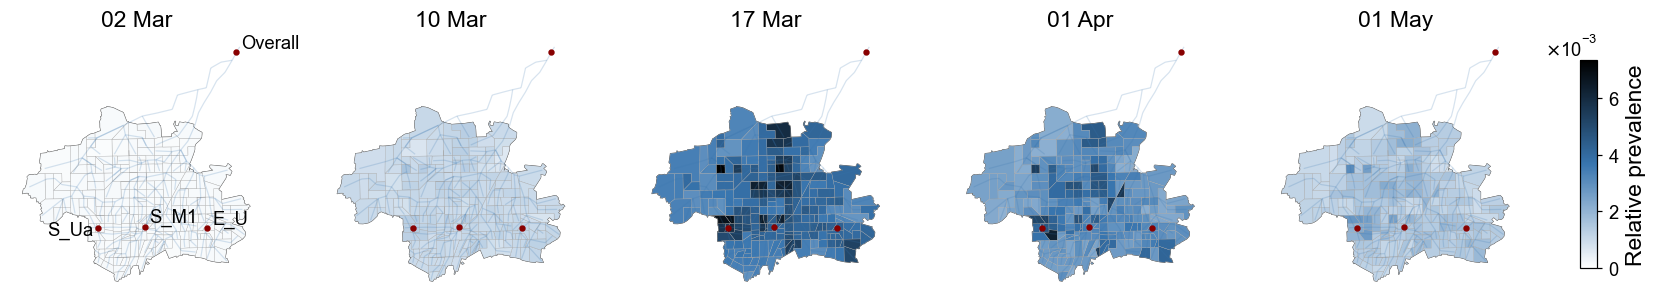

In [58]:
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter
cmap = mcolors.LinearSegmentedColormap.from_list(
    name="white_red",
    colors=[white, blue, black],
)
from matplotlib.colors import FuncNorm

# ScalarMappable as before
vmin=prevalence_uniform.relative_prevalence.min()
vmax=prevalence_uniform.relative_prevalence.max()

norm = mpl.colors.Normalize(
    vmin=vmin,
    vmax=vmax
)
#norm=FuncNorm(
#    (lambda x: np.log(x+1e-5), lambda x: np.exp(x-1e-5)),  # <-- notice the tuple here
#    vmin=vmin,
#    vmax=vmax
#)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []

fig, axs = plt.subplots(ncols=len(vertical_lines), figsize=(20*cm,6*cm), dpi=300)

for i in range(len(vertical_lines)):
    ax = axs[i]
    ax.set_title(vertical_lines[i].strftime("%d %b"))
    prevalence_uniform_sub = prevalence_uniform.loc[prevalence_uniform.Date == vertical_lines[i]]
    union_gdf.plot(ax=ax, color=very_light_grey, edgecolor="black", linewidth=0.5, alpha=0.8)
    gebiete_plot = gebiete.merge(prevalence_uniform_sub, left_on="Name", right_on="area", how="left")
    gebiete_plot.plot(
        ax=ax,
        column="relative_prevalence",
        cmap=cmap, #"viridis_r",
        norm=norm,
        vmin=vmin, vmax=vmax,
        edgecolor=medium_grey,
        linewidth=0.2,
        legend=False,
        legend_kwds={"label": "Relative prevalence", "shrink": 0.5}
    )
    # gebiete_plot[gebiete_plot.Name==62].plot(ax=ax, color=blue, edgecolor=medium_grey, linewidth=0.2, label="Area 62", zorder=10)
    txt_color = black
    abschnitte.plot(ax=ax, color=blue, label='Pipe', alpha=0.2, linewidth=0.8)
    knoten.iloc[[3, 12, 10, 5]].plot(ax=ax, color=red, label='Sampling station', zorder=20, markersize=10)


    # orientation left of point
    if i==0:
        for idx, row in knoten.iloc[[3, 12, 10, 5]].iterrows():# knoten.iloc[[7,10,11,12]].iterrows():
            print(idx)
            if idx ==3:
                ax.annotate(
                    text=row['name'],
                    xy=(row.geometry.x, row.geometry.y),
                    xytext=(-3, -5),
                    textcoords="offset points",
                    ha="right",
                    color=txt_color,
                    fontsize=0.8*15  # Change this value to your desired font size
                )
            else:
                ax.annotate(
                    text=row['name'],
                    xy=(row.geometry.x, row.geometry.y),
                    xytext=(3, 3),
                    textcoords="offset points",
                    ha="left",
                    color=txt_color,
                    fontsize=0.8*15  # Change this value to your desired font size
                )
    
    
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_axis_off()  # Remove plot borders

# manually carve out room on the right: [left, bottom, width, height] in figure fraction
cb_ax = fig.add_axes([0.92, 0.3, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cb_ax)
cbar.set_label("Relative prevalence")
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-3, 3))  # Adjust limits as needed
cb_ax.yaxis.set_major_formatter(formatter)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig("../plots/initialization_investigation/prevalence_pop8_uniform_v2.png", dpi=300, bbox_inches='tight')


In [34]:
knoten

,geometry,clear_name,name
0,POINT Z (692289.509 5342748.497 504.2),Schmidbartlangerstr.,N_Ub
1,POINT Z (692868.418 5339520.149 516.3),Schenkendorfstr.,S_M4
2,POINT Z (686255.746 5338038.467 524.6),Botanischer\nGarten,C_U
3,POINT Z (684534.741 5332563.932 543),Gräfelfinger\nStr.,S_Ua
4,POINT Z (680234.302 5337668.352 535),Am\nLangwieder\nBach,N_Uc
5,POINT Z (697521.89 5332513.56 536),Neue\nMessstelle 2,E_U
6,POINT Z (699601.505 5350974.465 504),WWT Gut Großlappen,SCE_D2
7,POINT Z (692499.805 5338677.075 518),Gyßlinger Becken,S_M3
8,POINT Z (687969.274 5329935.082 558),Neue\nMessstelle 1,S_Ub
9,POINT Z (699130.206 5352181.794 500),WWT Gut Marienhof,N_D


/tmp/ipykernel_106289/2837589020.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


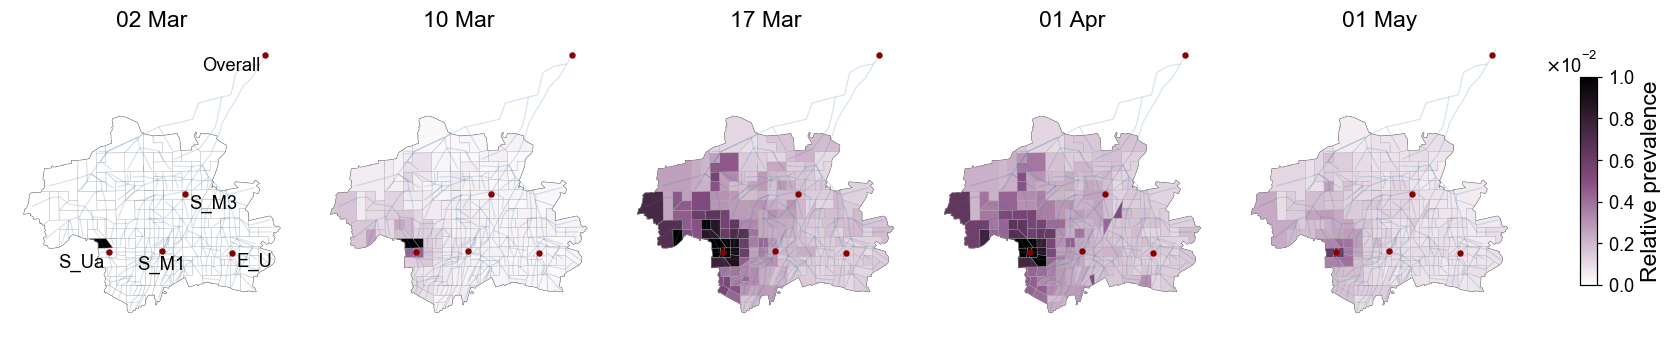

In [39]:
import matplotlib.colors as mcolors
import matplotlib as mpl
cmap = mcolors.LinearSegmentedColormap.from_list(
    name="white_red",
    colors=[white, purple, black],
)
from matplotlib.colors import FuncNorm

# ScalarMappable as before
vmin=prevalence_local57.relative_prevalence.min()
vmax=prevalence_local57.relative_prevalence.max()

norm = mpl.colors.Normalize(
    vmin=vmin,
    vmax=0.01,#vmax
)
#norm=FuncNorm(
#    (lambda x: np.log(x+1e-5), lambda x: np.exp(x-1e-5)),  # <-- notice the tuple here
#    vmin=vmin,
#    vmax=vmax
#)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []

fig, axs = plt.subplots(ncols=len(vertical_lines), figsize=(20*cm,6*cm), dpi=300)

for i in range(len(vertical_lines)):
    ax = axs[i]
    ax.set_title(vertical_lines[i].strftime("%d %b"))
    prevalence_local57_sub = prevalence_local57.loc[prevalence_local57.Date == vertical_lines[i]]
    union_gdf.plot(ax=ax, color=white, edgecolor="black", linewidth=0.5, alpha=0.8)
    gebiete_plot = gebiete.merge(prevalence_local57_sub, left_on="Name", right_on="area", how="left")
    gebiete_plot.plot(
        ax=ax,
        column="relative_prevalence",
        cmap=cmap, #"viridis_r",
        norm=norm,
        vmin=vmin, vmax=vmax,
        edgecolor=medium_grey,
        linewidth=0.2,
        legend=False,
        legend_kwds={"label": "Relative prevalence", "shrink": 0.5}
    )
    
    # gebiete_plot[gebiete_plot.Name==62].plot(ax=ax, color=blue, edgecolor=medium_grey, linewidth=0.2, label="Area 62", zorder=10)
    txt_color = black
    abschnitte.plot(ax=ax, color=blue, label='Pipe', alpha=0.2, linewidth=0.8)
    knoten.iloc[[3,7,10,5,12]].plot(ax=ax, color=red, label='Sampling station', zorder=20, markersize=10)

    # orientation left of point
    if i==0:
        for idx, row in knoten.iloc[[3,7,10,5,12]].iterrows():
            if idx == 3 or idx==10:
                ax.annotate(
                    text=row['name'],
                    xy=(row.geometry.x, row.geometry.y),
                    xytext=(-3, -10),
                    textcoords="offset points",
                    ha="right",
                    color=txt_color,
                    fontsize=0.8*15  # Change this value to your desired font size
                )
            elif idx == 12:
                ax.annotate(
                    text=row['name'],
                    xy=(row.geometry.x, row.geometry.y),
                    xytext=(0, -12),
                    textcoords="offset points",
                    ha="center",
                    color=txt_color,
                    fontsize=0.8*15  # Change this value to your desired font size
                )
            else:
                ax.annotate(
                    text=row['name'],
                    xy=(row.geometry.x, row.geometry.y),
                    xytext=(3, -9 ),
                    textcoords="offset points",
                    ha="left",
                    color=txt_color,
                    fontsize=0.8*15  # Change this value to your desired font size
                )
    
    
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_axis_off()  # Remove plot borders

# manually carve out room on the right: [left, bottom, width, height] in figure fraction
cb_ax = fig.add_axes([0.92, 0.3, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cb_ax)
cbar.set_label("Relative prevalence")
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))  # Adjust limits as needed
cb_ax.yaxis.set_major_formatter(formatter)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig("../plots/initialization_investigation/prevalence_pop8_local57_cropped.png", dpi=300, bbox_inches='tight')


/tmp/ipykernel_106289/562078287.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


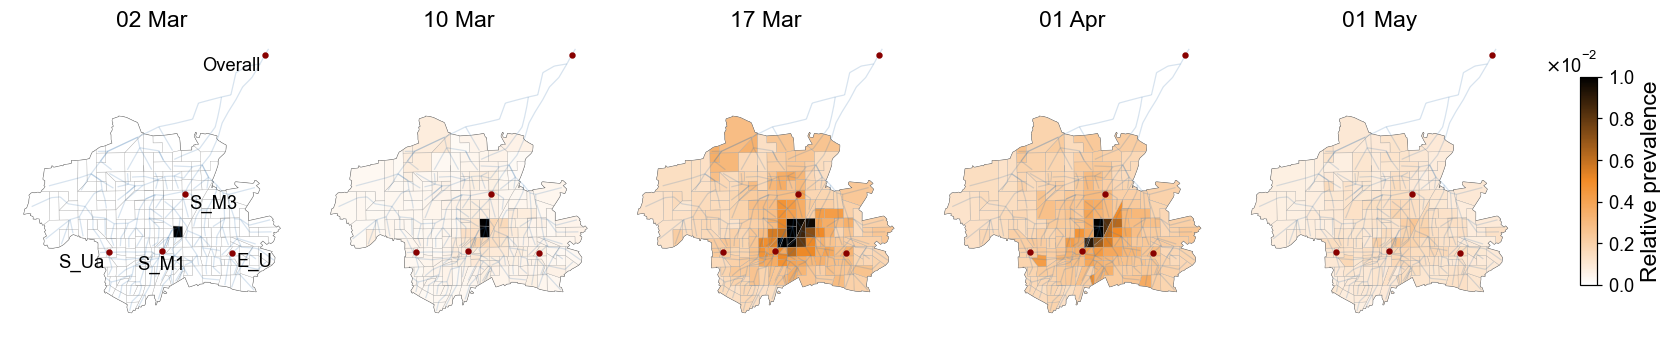

In [40]:
import matplotlib.colors as mcolors
import matplotlib as mpl
cmap = mcolors.LinearSegmentedColormap.from_list(
    name="white_red",
    colors=[white, orange, black],
)
from matplotlib.colors import FuncNorm

# ScalarMappable as before
vmin=prevalence_local.relative_prevalence.min()
vmax=prevalence_local.relative_prevalence.max()

norm = mpl.colors.Normalize(
    vmin=vmin,
    vmax=0.01,#vmax
)
#norm=FuncNorm(
#    (lambda x: np.log(x+1e-5), lambda x: np.exp(x-1e-5)),  # <-- notice the tuple here
#    vmin=vmin,
#    vmax=vmax
#)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []

fig, axs = plt.subplots(ncols=len(vertical_lines), figsize=(20*cm,6*cm), dpi=300)

for i in range(len(vertical_lines)):
    ax = axs[i]
    ax.set_title(vertical_lines[i].strftime("%d %b"))
    prevalence_local_sub = prevalence_local.loc[prevalence_local.Date == vertical_lines[i]]
    union_gdf.plot(ax=ax, color=white, edgecolor="black", linewidth=0.5, alpha=0.8)
    gebiete_plot = gebiete.merge(prevalence_local_sub, left_on="Name", right_on="area", how="left")
    gebiete_plot.plot(
        ax=ax,
        column="relative_prevalence",
        cmap=cmap, #"viridis_r",
        norm=norm,
        vmin=vmin, vmax=vmax,
        edgecolor=medium_grey,
        linewidth=0.2,
        legend=False,
        legend_kwds={"label": "Relative prevalence", "shrink": 0.5}
    )
    
    # gebiete_plot[gebiete_plot.Name==62].plot(ax=ax, color=blue, edgecolor=medium_grey, linewidth=0.2, label="Area 62", zorder=10)
    txt_color = black
    abschnitte.plot(ax=ax, color=blue, label='Pipe', alpha=0.2, linewidth=0.8)
    knoten.iloc[[3,7,10,5,12]].plot(ax=ax, color=red, label='Sampling station', zorder=20, markersize=10)

    # orientation left of point
    if i==0:
        for idx, row in knoten.iloc[[3,7,10,5,12]].iterrows():
            if idx == 3 or idx==10:
                ax.annotate(
                    text=row['name'],
                    xy=(row.geometry.x, row.geometry.y),
                    xytext=(-3, -10),
                    textcoords="offset points",
                    ha="right",
                    color=txt_color,
                    fontsize=0.8*15  # Change this value to your desired font size
                )
            elif idx == 12:
                ax.annotate(
                    text=row['name'],
                    xy=(row.geometry.x, row.geometry.y),
                    xytext=(0, -12),
                    textcoords="offset points",
                    ha="center",
                    color=txt_color,
                    fontsize=0.8*15  # Change this value to your desired font size
                )
            else:
                ax.annotate(
                    text=row['name'],
                    xy=(row.geometry.x, row.geometry.y),
                    xytext=(3, -9 ),
                    textcoords="offset points",
                    ha="left",
                    color=txt_color,
                    fontsize=0.8*15  # Change this value to your desired font size
                )
    
    
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_axis_off()  # Remove plot borders

# manually carve out room on the right: [left, bottom, width, height] in figure fraction
cb_ax = fig.add_axes([0.92, 0.3, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cb_ax)
cbar.set_label("Relative prevalence")
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))  # Adjust limits as needed
cb_ax.yaxis.set_major_formatter(formatter)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig("../plots/initialization_investigation/prevalence_pop8_local_cropped.png", dpi=300, bbox_inches='tight')


/tmp/ipykernel_35983/245039873.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


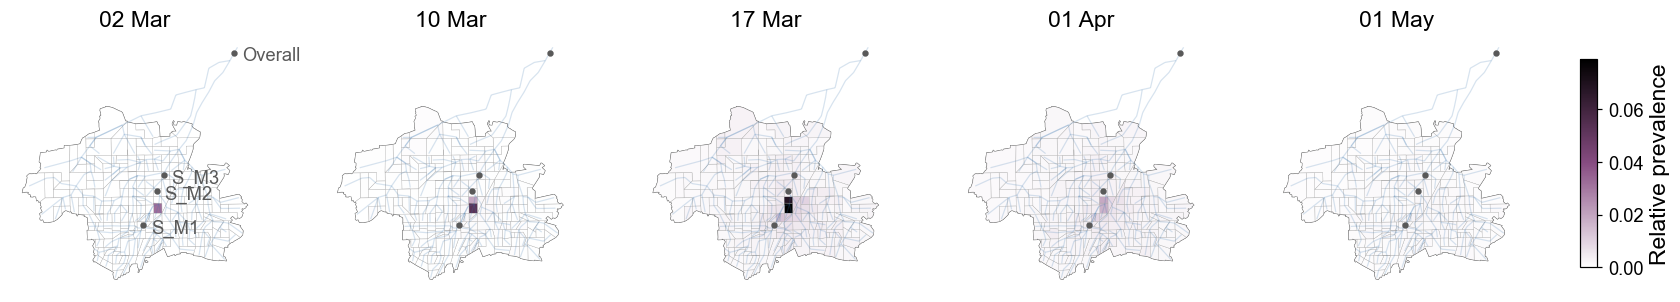

In [56]:
import matplotlib.colors as mcolors
import matplotlib as mpl
cmap = mcolors.LinearSegmentedColormap.from_list(
    name="white_red",
    colors=[white, purple, black],
)
from matplotlib.colors import FuncNorm

# ScalarMappable as before
vmin=prevalence_local.relative_prevalence.min()
vmax=prevalence_local.relative_prevalence.max()

norm = mpl.colors.Normalize(
    vmin=vmin,
    vmax=vmax
)
#norm=FuncNorm(
#    (lambda x: np.log(x+1e-5), lambda x: np.exp(x-1e-5)),  # <-- notice the tuple here
#    vmin=vmin,
#    vmax=vmax
#)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []

fig, axs = plt.subplots(ncols=len(vertical_lines), figsize=(20*cm,6*cm), dpi=300)

for i in range(len(vertical_lines)):
    ax = axs[i]
    ax.set_title(vertical_lines[i].strftime("%d %b"))
    union_gdf.plot(ax=ax, color=white, edgecolor="black", linewidth=0.5, alpha=0.8)
    prevalence_local_sub = prevalence_local.loc[prevalence_local.Date == vertical_lines[i]]
    gebiete_plot = gebiete.merge(prevalence_local_sub, left_on="Name", right_on="area", how="left")
    gebiete_plot.plot(
        ax=ax,
        column="relative_prevalence",
        cmap=cmap, #"viridis_r",
        norm=norm,
        vmin=vmin, vmax=vmax,
        edgecolor=medium_grey,
        linewidth=0.2,
        legend=False,
        legend_kwds={"label": "Relative prevalence", "shrink": 0.5}
    )
    # gebiete_plot[gebiete_plot.Name==62].plot(ax=ax, color=blue, edgecolor=medium_grey, linewidth=0.2, label="Area 62", zorder=10)
    txt_color = dark_grey
    abschnitte.plot(ax=ax, color=blue, label='Pipe', alpha=0.2, linewidth=0.8)
    knoten.iloc[[7,10,11,12]].plot(ax=ax, color=txt_color, label='Sampling station', zorder=20, markersize=10)

    # orientation left of point
    if i==0:
        for idx, row in knoten.iloc[[7,10,11,12]].iterrows():
            ax.annotate(
                text=row['name'],
                xy=(row.geometry.x, row.geometry.y),
                xytext=(5, -5),
                textcoords="offset points",
                ha="left",
                color=txt_color,
                fontsize=0.8*15  # Change this value to your desired font size
            )
    
    
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_axis_off()  # Remove plot borders

# manually carve out room on the right: [left, bottom, width, height] in figure fraction
cb_ax = fig.add_axes([0.92, 0.3, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cb_ax)
cbar.set_label("Relative prevalence")

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig("../plots/initialization_investigation/prevalence_pop8_local.png", dpi=300, bbox_inches='tight')


## Wastewater visualization

In [5]:
# load data
df_local = pd.read_csv("../../preprocessing/preprocessed_data/pop8_local/substances/decay_Rain_output_scaled.csv")
df_local = df_local[(df_local["variable"] == "COV19") & (df_local["manhole"].isin(manhole_names.keys()))]
df_local["location"] = df_local["manhole"].map(manhole_names)
df_local = df_local[df_local["location"].isin(locations_sub)]

# load data
df_local57 = pd.read_csv("../../preprocessing/preprocessed_data/pop8_local57/substances/decay_Rain_output_scaled.csv")
df_local57 = df_local57[(df_local57["variable"] == "COV19") & (df_local57["manhole"].isin(manhole_names.keys()))]
df_local57["location"] = df_local57["manhole"].map(manhole_names)
df_local57 = df_local57[df_local57["location"].isin(locations_sub)]

df_uniform = pd.read_csv("../../preprocessing/preprocessed_data/pop8/substances/decay_Rain_output_scaled.csv")
df_uniform = df_uniform[(df_uniform["variable"] == "COV19") & (df_uniform["manhole"].isin(manhole_names.keys()))]
df_uniform["location"] = df_uniform["manhole"].map(manhole_names)
df_uniform = df_uniform[df_uniform["location"].isin(locations_sub)]

In [6]:
df_uniform["Date"] = pd.to_datetime(start_date) + pd.to_timedelta(df_uniform["time_in_minutes"], unit='minutes')
df_local["Date"] = pd.to_datetime(start_date) + pd.to_timedelta(df_local["time_in_minutes"], unit='minutes')
df_local57["Date"] = pd.to_datetime(start_date) + pd.to_timedelta(df_local57["time_in_minutes"], unit='minutes')

In [9]:
# select relevant dates
df_local_sub = df_local#.loc[(df_local["Date"] >= pd.to_datetime("2020-02-20"))&(df_local["Date"] <= pd.to_datetime("2020-07-03")),:]
df_uniform_sub = df_uniform#.loc[(df_uniform["Date"] >= pd.to_datetime("2020-02-20"))&(df_uniform["Date"] <= pd.to_datetime("2020-07-03")),:]

S_Ua
S_M1
S_M3
E_U
Overall


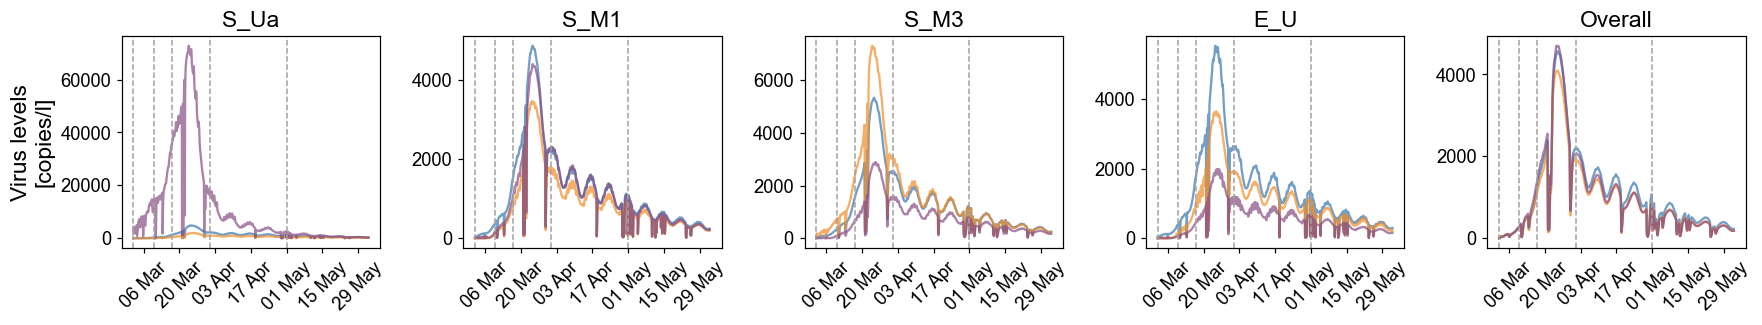

In [ ]:
# Sort locations for consistency

# Set up 4x1 subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16.3, 3.2))#, sharey=True)
axes = axes.flatten()

for i, location in enumerate(locations_sub, start=0):  
    print(location)  
    ax = axes[i]
    #ax.grid(True)

    group = df_uniform.loc[df_uniform["location"] == location,:].copy()
    sns.lineplot(data=group, x="Date", y="value", color=blue, ax=ax, estimator=np.mean, errorbar=None, alpha=0.7)
    group = df_local.loc[df_local["location"] == location,:].copy()
    sns.lineplot(data=group, x="Date", y="value", color=orange, ax=ax, estimator=np.mean, errorbar=None, alpha=0.7)
    group = df_local57.loc[df_local57["location"] == location,:].copy()
    sns.lineplot(data=group, x="Date", y="value", color=purple, ax=ax, estimator=np.mean, errorbar=None, alpha=0.7)

    ax.set_title(location)
    if i%5 == 0:
        ax.set_ylabel("Virus levels\n[copies/l]")
    else:
        ax.set_ylabel("")

#vertical_lines = ["2020-03-02 00:00", "2020-03-16 00:00", "2020-04-01 00:00", "2020-05-01 00:00"]



# Set x-labels for bottom row only
for ax in axes:
    ax.set_xlabel("")
    
    for label in ax.get_xticklabels():
        label.set_rotation(45)

import matplotlib.dates as mdates

# Set major ticks every 7 days
seven_days = mdates.DayLocator(interval=14)
for ax in axes:
    for vline in vertical_lines:
        ax.axvline(pd.to_datetime(vline), color=medium_grey, linestyle='--', linewidth=1)
    ax.xaxis.set_major_locator(seven_days)
    for lbl in ax.get_xticklabels():
        lbl.set_rotation(45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))  # Format without year

#plt.legend()
# Add overall title
plt.tight_layout()
plt.show()
fig.savefig("../plots/initialization_investigation/local_local57_vs_uniform_initialization_whole_timeframe.png", bbox_inches='tight', dpi=300)


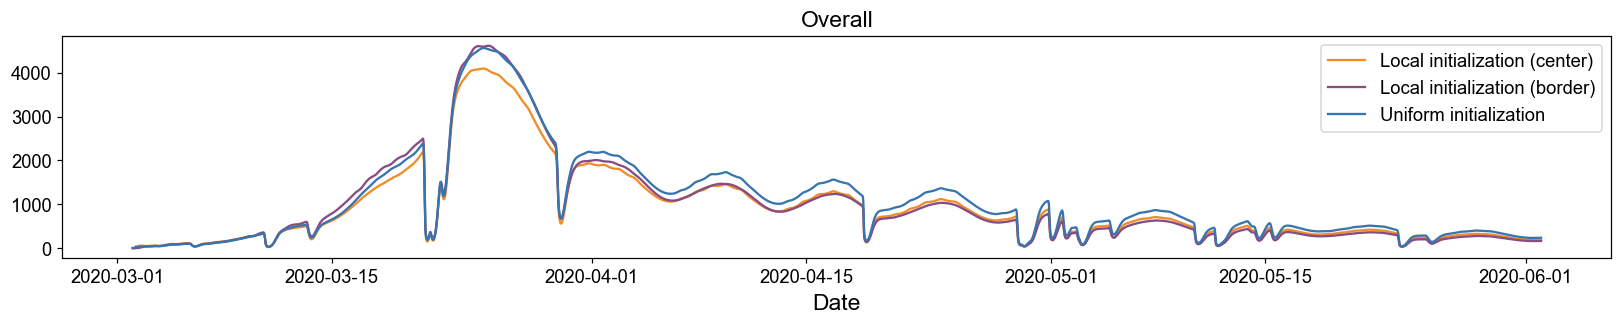

In [58]:
# Sort locations for consistency

# Set up 4x1 subplots
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 3.2))#, sharey=True)



ax = axes
#ax.grid(True)
group = df_local.loc[df_local["location"] == location,:].copy()
sns.lineplot(data=group, x="Date", y="value", color=orange, ax=ax, estimator=np.mean, errorbar=None, label="Local initialization (center)")
group = df_local57.loc[df_local57["location"] == location,:].copy()
sns.lineplot(data=group, x="Date", y="value", color=purple, ax=ax, estimator=np.mean, errorbar=None, label="Local initialization (border)")

group = df_uniform.loc[df_uniform["location"] == location,:].copy()
sns.lineplot(data=group, x="Date", y="value", color=blue, ax=ax, estimator=np.mean, errorbar=None, label="Uniform initialization")


ax.set_title(location)
if i%5 == 0:
    ax.set_ylabel("Virus levels\n[copies/l]")
else:
    ax.set_ylabel("")

import matplotlib.dates as mdates

# Set major ticks every 7 days
seven_days = mdates.DayLocator(interval=14)
ax.legend()

#plt.legend()
# Add overall title
plt.tight_layout()
plt.show()
fig.savefig("../plots/initialization_investigation/legend.png", bbox_inches='tight', dpi=300)
